Import statement

In [2]:
import tensorflow as tf
from keras import backend as K
from google.colab import drive
drive.mount('/gdrive')
import os
import re
import shutil
import tarfile
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import IPython.display as display
import tensorboardcolab as tbc
tbc = tbc.TensorBoardColab()

Mounted at /gdrive
Wait for 8 seconds...
TensorBoard link:
https://3f91bf49.ngrok.io


Write in tensorflow 

In [0]:
writer = tbc.get_writer()

W0614 19:10:20.196803 140657897322368 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tensorboardcolab/core.py:49: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Defining the variables

In [0]:
batch_size = 10
nb_boxes=1
grid_w=2
grid_h=2
cell_w=14
cell_h=14
img_w=28
img_h=28
img_channels = 1
input_shape = (None, img_w, img_h, img_channels)

Extract function takes data record and return images and data

In [0]:
def extract_fn(data_record):
    features = {
      'image': tf.FixedLenFeature([], tf.string),
      'label': tf.FixedLenFeature([5], tf.float32)
    }
    data = tf.parse_single_example(data_record, features)
    img1 = tf.decode_raw(data['image'], tf.float32)
    img1 = tf.reshape(img1, (img_w, img_h, img_channels)) #reshape to 28 x 28 x 1
    img1 = tf.image.per_image_standardization(img1) #Standardizing
    return img1, data['label']

In [0]:
files_pattern = '/gdrive/My Drive/indic2019/TFRecords/*.tfrecord' #file pattern for tf record
test_pattern = '/gdrive/My Drive/indic2019/Test/*.tfrecord' #file pattern for testing it on the test pattern
test_image = '/gdrive/My Drive/indic2019/images/10_10.jpg'

<h3> Input function</h3>
  <ul>
    <li>Input parameters are files pattern(for taking data from the input), batch_size and mode(predict,eval and train)</li>
  <li>Returns features and label in case of eval and train and features in case of predict</li>
    </ul>


In [0]:
def input_fn(files_pattern,batch_size, mode):
  print(batch_size)
  files = tf.data.Dataset.list_files(files_pattern, shuffle=True)
  dataset = files.apply(tf.contrib.data.parallel_interleave( lambda filename: tf.data.TFRecordDataset(filename), cycle_length=1)) 
  #T parallel_interleave-HIS FUNCTION IS DEPRECATED. (not exactly know)
    
  #three variables for three mode
  is_training = (mode == tf.estimator.ModeKeys.TRAIN)
  is_eval = (mode == tf.estimator.ModeKeys.EVAL)
  is_predict = (mode== tf.estimator.ModeKeys.PREDICT)
  
  buffer_size = batch_size * 2 + 1
  dataset = dataset.shuffle(buffer_size=buffer_size)

  # Transformation
  dataset = dataset.map(extract_fn)
  
  if is_training or is_predict:
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(2 * batch_size)
    
  if is_eval:
    buffer_size = batch_size * 10
    dataset = dataset.shuffle(buffer_size=buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(10 * batch_size)

  image, label = dataset.make_one_shot_iterator().get_next()
  features = {'images': image}
  
  if is_training or is_eval:
    return features, label
  
  if is_predict:
    return features 

<h3> Custom loss </h3>

In [0]:

def custom_loss(labels,logits):
  
  print("Printing labels")
  print(labels)
  
  true_confidence = labels[:,0]
  true_x=labels[:,1]
  true_y=labels[:,2]
  true_w=labels[:,3]
  true_h=labels[:,4]

  predict_confidence=logits[:,0]
  predict_x=logits[:,1]
  predict_y=logits[:,2]
  predict_w=logits[:,3]
  predict_h=logits[:,4]	

  xy_loss= K.square(true_x-predict_x) + K.square(true_y-predict_y)
  wh_loss= K.square(K.sqrt(true_w)-K.sqrt(predict_w))+ K.square(K.sqrt(true_h)-K.sqrt(predict_h))

  con_loss=K.square(true_confidence-predict_confidence)

  loss= xy_loss + wh_loss + con_loss
  return tf.math.reduce_mean(loss)

<h3>Bounding Box</h3>
Returns coordinates of bounding box

In [0]:
#Shape of y : conf x y w h

def convert_to_coord(y):
  coord= []
  bb_box_width = y[:,3] * img_w
  bb_box_height = y[:,4] * img_h
  center_x = y[:,1] * img_w
  center_y = y[:,2] * img_h
  coord.append((center_x - (bb_box_width / 2)))
  coord.append((center_y - (bb_box_height / 2)))
  coord.append((center_x + (bb_box_width / 2)))
  coord.append((center_y + (bb_box_height / 2)))
  
  return coord
  

<h3>IOU Loss</h3>

In [0]:
def iou_loss(labels,logits):
  #Convert the arrays to absolute coordinates
  coord_labels = convert_to_coord(labels)
  coord_logits = convert_to_coord(logits)
  
  # Calculate the (y1, x1, y2, x2) coordinates of the intersection of box1 and box2. Calculate its Area.
  xi1 = tf.math.maximum((coord_labels[0]), (coord_logits[0]))
  yi1 = tf.math.maximum((coord_labels[1]), (coord_logits[1]))
  xi2 = tf.math.minimum((coord_labels[2]), (coord_logits[2]))
  yi2 = tf.math.minimum((coord_labels[3]), (coord_logits[3]))
  inter_area = tf.math.maximum((yi2-yi1), 0) * tf.math.maximum((xi2-xi1), 0)
  
  # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
  box1_area = (coord_labels[3] - coord_labels[1])*(coord_labels[2]- coord_labels[0])
  box2_area = (coord_logits[3] - coord_logits[1])*(coord_logits[2]- coord_logits[0])
  union_area = (box1_area + box2_area) - inter_area
  # compute the IoU
  
  iou =inter_area / union_area

  return iou
  

<h3>Feature Columns</h3>
The feature columns is an intermediaries between raw data and Estimators.<br/>
Feature columns bridge raw data with the data your model needs.


In [0]:
def get_feature_columns():
  feature_columns = {'images': tf.feature_column.numeric_column('images', (28, 28, 1))}
  return feature_columns

<h3>Base Model</h3>

In [0]:
def base_model(input,batch_size, input_shape):
  
  #print(input.shape)
  #print(batch_size)
  
  
  #Conv Layer - 1
  x = tf.keras.layers.Conv2D(16,(5,5), input_shape = input_shape , name="Conv_1",
                             use_bias=True, kernel_initializer='glorot_uniform', 
                             bias_initializer='zeros')(input)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  x= tf.keras.layers.MaxPooling2D()(x)
  
  x = tf.keras.layers.Conv2D(16,(5,5), input_shape = input_shape , name="Conv_2",
                             use_bias=True, kernel_initializer='glorot_uniform', 
                             bias_initializer='zeros')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  
  #print(x)
  
  #Flatten it out
  x = tf.keras.layers.Flatten(name="Flatten_1")(x)
  #print("After flatten")
  #print(x)
  
  #Dense layer
  x = tf.keras.layers.Dense(1024, activation="sigmoid", name="Dense1")(x)
  #print(x)
  x = tf.keras.layers.Dense(5, activation='sigmoid')(x)
  #print(x)
  # x = tf.keras.layers.Reshape((2*2, (1*5)), name= 'model_final_reshape')(x)
  
  return x

<h3>Model Function</h3>
<ul>
  <li>input is features, labels, mode and parameters</li>
</ul>



In [0]:
def model_fn(features, labels, mode, params):
                                                                                                
  feature_columns = list(get_feature_columns().values())
  images = tf.feature_column.input_layer(features=features, feature_columns=feature_columns)
  images = tf.reshape(images, shape=(-1, 28, 28, 1),name='my_reshape')

  print("Printing labels in model function")
  print(labels)

  # Calculate logits through CNN                                                                                                            
  logits = base_model(images,batch_size, input_shape)

  # Create the input layers from the features 
  if mode in (tf.estimator.ModeKeys.TRAIN, tf.estimator.ModeKeys.EVAL):
    global_step = tf.train.get_or_create_global_step()#create default graph
    loss=custom_loss(labels,logits) #loss 
    iou = iou_loss(labels,logits) 
    tf.summary.scalar('IOU', tf.math.reduce_mean(iou))
    tf.summary.scalar('Loss', loss)

  if mode == tf.estimator.ModeKeys.PREDICT:
    predictions = {'coordinates': logits}
    export_outputs = {'coordinates': tf.estimator.export.PredictOutput(predictions)}
    return tf.estimator.EstimatorSpec(mode, predictions=predictions, export_outputs=export_outputs)
  
  if mode == tf.estimator.ModeKeys.EVAL:
    iou = iou_loss(labels,logits)
    eval_metric_ops = {'iou_eval': tf.metrics.mean(iou)}
    return tf.estimator.EstimatorSpec(mode, loss=loss, eval_metric_ops=eval_metric_ops)

  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001,beta1=0.9,beta2=0.999,epsilon=1e-08,use_locking=False,name='Adam')
    train_op = optimizer.minimize(loss, global_step=global_step)
    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)
  

Preprocess is used in serving_input_fn

In [0]:
def preprocess(image):
  image_contents = tf.read_file(image)
  img_decoded = tf.image.decode_jpeg(image_contents, channels=img_channels)
  image_converted = tf.image.convert_image_dtype(img_decoded, dtype=tf.float32)
  img_expanded = tf.expand_dims(image_converted, 0)
  img_resize = tf.image.resize_bilinear(img_expanded,(img_h, img_w))
  img_squeezed = tf.squeeze(img_resize,0)
  img_standardized = tf.image.per_image_standardization(img_squeezed)
  return img_standardized


In [0]:
def read_and_preprocess(filename):
    # decode the image file starting from the filename
    image_contents = tf.read_file(filename)
    image = tf.image.decode_jpeg(image_contents, channels=img_channels)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) # 0-1
    image= tf.reshape(image, (-1, img_w, img_h, img_channels))
    image = tf.image.per_image_standardization(image)
    return image

In [0]:
read_and_preprocess('https://drive.google.com/open?id=1a13hnMqYvoqOUMczCdhAfBbkqVm9GzFa')

<tf.Tensor 'per_image_standardization_4:0' shape=(?, 28, 28, 1) dtype=float32>

In [0]:
receiver_tensor = {'image_bytes': tf.placeholder(dtype=tf.string, shape=[1])}
print(receiver_tensor['image_bytes'])

Tensor("Placeholder_11:0", shape=(1,), dtype=string)


In [0]:
receiver_tensor = {'images': tf.placeholder(shape=[None, 28, 28, 1], dtype=tf.string)}

<h3>Serving function</h3>

In [0]:
def serving_input_fn():
  receiver_tensor = {'images': tf.placeholder(shape=[None, 28, 28, 1], dtype=tf.string)}
  features = {'images': tf.map_fn(preprocess, receiver_tensor['images'])}
  return tf.estimator.export.ServingInputReceiver(features, receiver_tensor)

In [0]:
run_config = tf.estimator.RunConfig(model_dir='./Graph', save_summary_steps=10, save_checkpoints_secs = 300, keep_checkpoint_max = 5)
estimator = tf.estimator.Estimator(model_fn=model_fn, config=run_config)

# There is another Exporter named FinalExporter which exports the serving graph and checkpoints at the end.

exporter = tf.estimator.LatestExporter(
  name='Serve',
  serving_input_receiver_fn=serving_input_fn,
  assets_extra=None,
  as_text=False,
  exports_to_keep=5)

train_spec = tf.estimator.TrainSpec(input_fn= lambda:input_fn(files_pattern, batch_size, mode=tf.estimator.ModeKeys.TRAIN))

eval_spec = tf.estimator.EvalSpec(lambda: input_fn(files_pattern,  batch_size , mode=tf.estimator.ModeKeys.EVAL), exporters=exporter)

W0707 16:58:28.287952 139952384415616 model_fn.py:630] Estimator's model_fn (<function model_fn at 0x7f48d0008ea0>) includes params argument, but params are not passed to Estimator.


In [0]:
writer.add_graph(tf.get_default_graph())
writer.flush()

In [0]:
tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

In [0]:
estimator.train(lambda: input_fn(files_pattern,  batch_size , mode=tf.estimator.ModeKeys.TRAIN), steps=100)

10
Printing labels in model function
Tensor("IteratorGetNext:1", shape=(?, 5), dtype=float32, device=/device:CPU:0)
Printing labels
Tensor("IteratorGetNext:1", shape=(?, 5), dtype=float32, device=/device:CPU:0)


W0707 16:58:33.496477 139952384415616 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
W0707 16:58:33.591876 139952384415616 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1066: get_checkpoint_mtimes (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file utilities to get mtimes.


In [0]:
estimator.evaluate(lambda: input_fn(files_pattern,  batch_size , mode=tf.estimator.ModeKeys.EVAL), steps=100)

In [0]:
l = estimator.predict(lambda: input_fn(test_pattern,  1 , mode=tf.estimator.ModeKeys.PREDICT))

In [0]:
def plot_bb(preds):
  height_image = 28
  width_image = 28
  bb_box_width = preds[3] * width_image
  bb_box_height = preds[4] * height_image
  center_x = preds[1] * width_image
  center_y = preds[2] * height_image
  x_min = (center_x - (bb_box_width / 2))
  y_min = (center_y - (bb_box_height / 2))
  print(x_min)
  print(y_min)
  print(bb_box_width)
  print(bb_box_height)
  
  
  with tf.Session() as sess:
    sess.graph._unsafe_unfinalize()

  dataset = tf.data.TFRecordDataset(['/gdrive/My Drive/indic2019/Test/1.tfrecord'])
  dataset = dataset.map(extract_fn)
  image, label = dataset.make_one_shot_iterator().get_next()

  with tf.Session() as sess:
    sess.graph._unsafe_unfinalize()
    img = sess.run(image)
  img = img[:,:,0]
  print(img.shape)
  fig,ax = plt.subplots(1)
  ax.imshow(img)
  rect = patches.Rectangle((x_min,y_min),bb_box_width,bb_box_height,linewidth=1,edgecolor='r',facecolor='none')
  ax.add_patch(rect)
  plt.show()
  
  with tf.Session() as sess:
    sess.graph._unsafe_unfinalize()

  dataset = tf.data.TFRecordDataset(['/gdrive/My Drive/indic2019/Test/2.tfrecord'])
  dataset = dataset.map(extract_fn)
  image, label = dataset.make_one_shot_iterator().get_next()

  with tf.Session() as sess:
    sess.graph._unsafe_unfinalize()
    img = sess.run(image)
  img = img[:,:,0]
  print(img.shape)
  fig,ax = plt.subplots(1)
  ax.imshow(img)
  rect = patches.Rectangle((x_min,y_min),bb_box_width,bb_box_height,linewidth=1,edgecolor='r',facecolor='none')
  ax.add_patch(rect)
  plt.show()

In [0]:
count = 0
for it in l:
  preds = it['coordinates']
  if count == 0:
    break
print(preds)

1
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./Graph/model.ckpt-225
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
[0.995943   0.5148804  0.536006   0.86078393 0.8441564 ]


2.3656766414642334
3.1899778842926025
24.10195016860962
23.6363787651062
(28, 28)


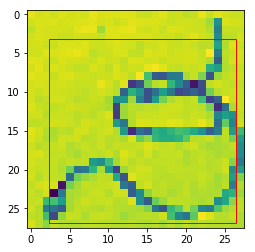

(28, 28)


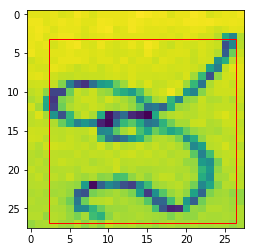

In [0]:
plot_bb(preds)

Save the model

In [0]:
estimator.export_saved_model('saved_model', serving_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['coordinates', 'serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from ./Graph/model.ckpt-225
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: saved_model/temp-b'1559848351'/saved_model.pb


b'saved_model/1559848351'

In [0]:
#To export files from google drive to google ml bucket
#!gsutil cp '/gdrive/My Drive/indic2019/Test/*.tfrecord' 'gs://indic2019/indic2019'
  

In [0]:
print(tf.__version__)